In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

In [2]:
users = pd.read_csv('takehome_users.csv',encoding='latin-1')
eng = pd.read_csv('takehome_user_engagement.csv', encoding='latin-1')

# Wrangling

## Load Data

In [3]:
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


In [4]:
eng

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


## Wrangle eng

In [5]:
eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [6]:
eng.user_id.unique().shape[0]

8823

Only 8,823 users reflected in this table. The rest of the 12,000 users probably never logged on after creating their account.

In [7]:
# Convert time_stamp to datetime and remove time component
eng.time_stamp = pd.to_datetime(eng.time_stamp)

In [8]:
eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [9]:
# Find earliest timestamp
eng.time_stamp.min()

Timestamp('2012-05-31 08:20:06')

In [10]:
# Find latest timestamp
eng.time_stamp.max()

Timestamp('2014-06-06 14:58:50')

In [11]:
# Create column representing the year and week of the user visit
eng['year_week'] = eng.time_stamp.apply(lambda x: x.strftime('%Y-%U'))

In [12]:
# Drop time_stamp
eng.drop(columns='time_stamp', inplace=True)

In [13]:
# Group dataframe by user_id and year_week. Sum to determine the number of days they 
# accessed their account in each week
eng = eng.groupby(['user_id', 'year_week']).sum()

In [14]:
# If a user accessed their account >= 3 times in one week, they are considered an adopted user. Create column for
# this label.
eng['adopted'] = eng.visited.apply(lambda x: True if x >= 3 else False)

In [15]:
# Reset index
eng = eng.reset_index()

In [16]:
# Initialize empty column for the date a user was considered adopted. Set to False to start, as the assumption is that
# users are not considered adopted.
eng['date_adopted'] = False

In [17]:
# for loop to fill values in date_adopted with the first week that a user accessed their account >= 3 times.
# This will help understand the timeframe it takes for a user to be considered adopted after creating their account.

for i in eng.user_id.unique():
    
    subsetmask = eng.loc[:, 'user_id'] == i
    
    if True in eng.loc[subsetmask].adopted.unique():
        dateadopted = eng.loc[subsetmask].year_week.min()
        eng.loc[subsetmask, 'date_adopted'] = dateadopted
        eng.loc[subsetmask, 'adopted'] = True
        
    else:
        continue

In [18]:
# Drop unneeded columns
eng.drop(columns=['year_week', 'visited'], inplace=True)

In [19]:
# Consolidate dataframe with one row for each user
eng = eng.groupby(['user_id', 'adopted', 'date_adopted']).count().reset_index()

In [20]:
# inspect wrangled dataframe
eng

,user_id,adopted,date_adopted
0,1,False,False
1,2,False,False
2,3,False,False
3,4,False,False
4,5,False,False
...,...,...,...
8818,11996,False,False
8819,11997,False,False
8820,11998,False,False
8821,11999,False,False


In [21]:
eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8823 entries, 0 to 8822
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       8823 non-null   int64 
 1   adopted       8823 non-null   bool  
 2   date_adopted  8823 non-null   object
dtypes: bool(1), int64(1), object(1)
memory usage: 146.6+ KB


## Join Tables

In [22]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [23]:
users.object_id.unique().shape[0]

12000

The user table contains all 12,000 user ids. This will need to be a left merge, joining the eng table onto the user table.

In [24]:
# rename object_id column to match eng table
users.rename(columns={'object_id':'user_id'}, inplace=True)

In [25]:
df = users.merge(eng, 
            how='left',
            on='user_id')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adopted                     8823 non-null   object 
 11  date_adopted                8823 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 1.2+ MB


## Wrangle Joined Table

In [27]:
# extract domain from email address
df.email = df.email.apply(lambda x: re.search('(.*@)(.*)(\..*)', x)[2])

In [28]:
# Drop unnecessary columns
df.drop(columns=['user_id', 'name'], inplace=True)

In [29]:
# Replace False values in date_adopted with null values
df.date_adopted.replace(False, np.nan, inplace=True)

In [30]:
# Convert creation_time and last_session_creation_time to datetime
df.creation_time = pd.to_datetime(df.creation_time).dt.date
df.last_session_creation_time = pd.to_datetime(df.last_session_creation_time, unit='s').dt.date

In [31]:
# Create column with creation time in Y%U% strformat in a new column
df['creation_time_week_of_year'] = df.creation_time.apply(lambda x: x.strftime('%Y-%U'))

In [32]:
# Pull columns into separate dataframe for further analysis
creation_to_adoption_time = df.loc[df.loc[:, 'adopted'] == True][['date_adopted', 'creation_time_week_of_year']]

In [33]:
# Drop unneeded columns
df.drop(columns=['date_adopted', 'creation_time_week_of_year'], inplace=True)

In [34]:
creation_to_adoption_time

,date_adopted,creation_time_week_of_year
9,2013-02,2013-02
19,2014-10,2014-09
41,2012-46,2012-46
42,2013-00,2012-53
49,2012-23,2012-23
...,...,...
11964,2014-17,2014-16
11966,2014-02,2014-02
11968,2013-21,2013-21
11974,2013-12,2013-11


In [35]:
df

,creation_time,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,2014-04-22,yahoo,GUEST_INVITE,2014-04-22,1,0,11,10803.0,False
1,2013-11-15,gustr,ORG_INVITE,2014-03-31,0,0,1,316.0,False
2,2013-03-19,gustr,ORG_INVITE,2013-03-19,0,0,94,1525.0,False
3,2013-05-21,yahoo,GUEST_INVITE,2013-05-22,0,0,1,5151.0,False
4,2013-01-17,yahoo,GUEST_INVITE,2013-01-22,0,0,193,5240.0,False
...,...,...,...,...,...,...,...,...,...
11995,2013-09-06,gustr,ORG_INVITE,2013-09-06,0,0,89,8263.0,False
11996,2013-01-10,gmail,SIGNUP_GOOGLE_AUTH,2013-01-15,0,0,200,NaN,False
11997,2014-04-27,cuvox,GUEST_INVITE,2014-04-27,1,1,83,8074.0,False
11998,2012-05-31,iuxiw,PERSONAL_PROJECTS,2012-06-02,0,0,6,NaN,False


In [36]:
df.email.unique().shape[0]

1184

In [37]:
df.email.value_counts().describe()

count    1184.000000
mean       10.135135
std       143.416778
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      3562.000000
Name: email, dtype: float64

In [38]:
# To reduce cardinality of data, convert any email domain that appears < 10 times into a single category of 'other'
otheremails = []

for i in df.email.unique():
    if df.email.value_counts()[i] < 10:
        otheremails.append(i)
    else:
        continue

In [39]:
# Replace emails
df.replace(dict.fromkeys(otheremails, 'other'), inplace=True)

In [40]:
# Confirm cardinality reduced significantly
df.email.unique().shape[0]

7

###### Trying to model by dropping org_id and seeing what happens

In [41]:
df.drop(columns=['org_id'], inplace=True)

old code

In [41]:
# Change org_id to str for one hot encoding later
df.org_id = df.org_id.astype(str)

In [42]:
df.org_id.unique().shape[0]

417

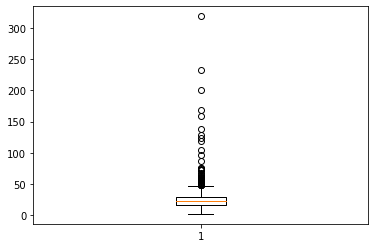

In [43]:
_ = plt.boxplot(df.org_id.value_counts())

In [44]:
# To reduce cardinality of data, convert any email domain that appears < 10 times into a single category of 'other'
otherorgs = []

for i in df.org_id.unique():
    if df.org_id.value_counts()[i] <= 100:
        otherorgs.append(i)
    else:
        continue

In [45]:
# Replace org_ids
df.replace(dict.fromkeys(otherorgs, 'other'), inplace=True)

In [46]:
df.org_id.unique().shape[0]

11

end of old code

### Deal with Null Values

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_time               12000 non-null  object 
 1   email                       12000 non-null  object 
 2   creation_source             12000 non-null  object 
 3   last_session_creation_time  8823 non-null   object 
 4   opted_in_to_mailing_list    12000 non-null  int64  
 5   enabled_for_marketing_drip  12000 non-null  int64  
 6   invited_by_user_id          6417 non-null   float64
 7   adopted                     8823 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 843.8+ KB


In [43]:
# Nulls in adopted converted to False
df.adopted = df.adopted.apply(lambda x: False if x is np.nan else x)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_time               12000 non-null  object 
 1   email                       12000 non-null  object 
 2   creation_source             12000 non-null  object 
 3   last_session_creation_time  8823 non-null   object 
 4   opted_in_to_mailing_list    12000 non-null  int64  
 5   enabled_for_marketing_drip  12000 non-null  int64  
 6   invited_by_user_id          6417 non-null   float64
 7   adopted                     12000 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(4)
memory usage: 761.7+ KB


In [45]:
# Convert last_session_creation_time into boolean column. True if they logged into their account at least once,
# False if not
df['logged_in_atleast_once'] = df.last_session_creation_time.apply(lambda x: False if x is np.nan else True)

In [46]:
# Drop last_session_creation_time
df.drop(columns=['last_session_creation_time'], inplace=True)

In [47]:
# Convert invited_by_user_id to boolean column. True if they were invited, False if not.
df['invited_by_user'] = df.invited_by_user_id.apply(lambda x: False if x is np.nan else True)

In [48]:
# Drop invited_by_user_id column
df.drop(columns=['invited_by_user_id'], inplace=True)

In [49]:
# Drop creation_time column
df.drop(columns=['creation_time'], inplace=True)

## Make Dummy Variables

In [50]:
df = pd.get_dummies(df, drop_first=True)

## EDA

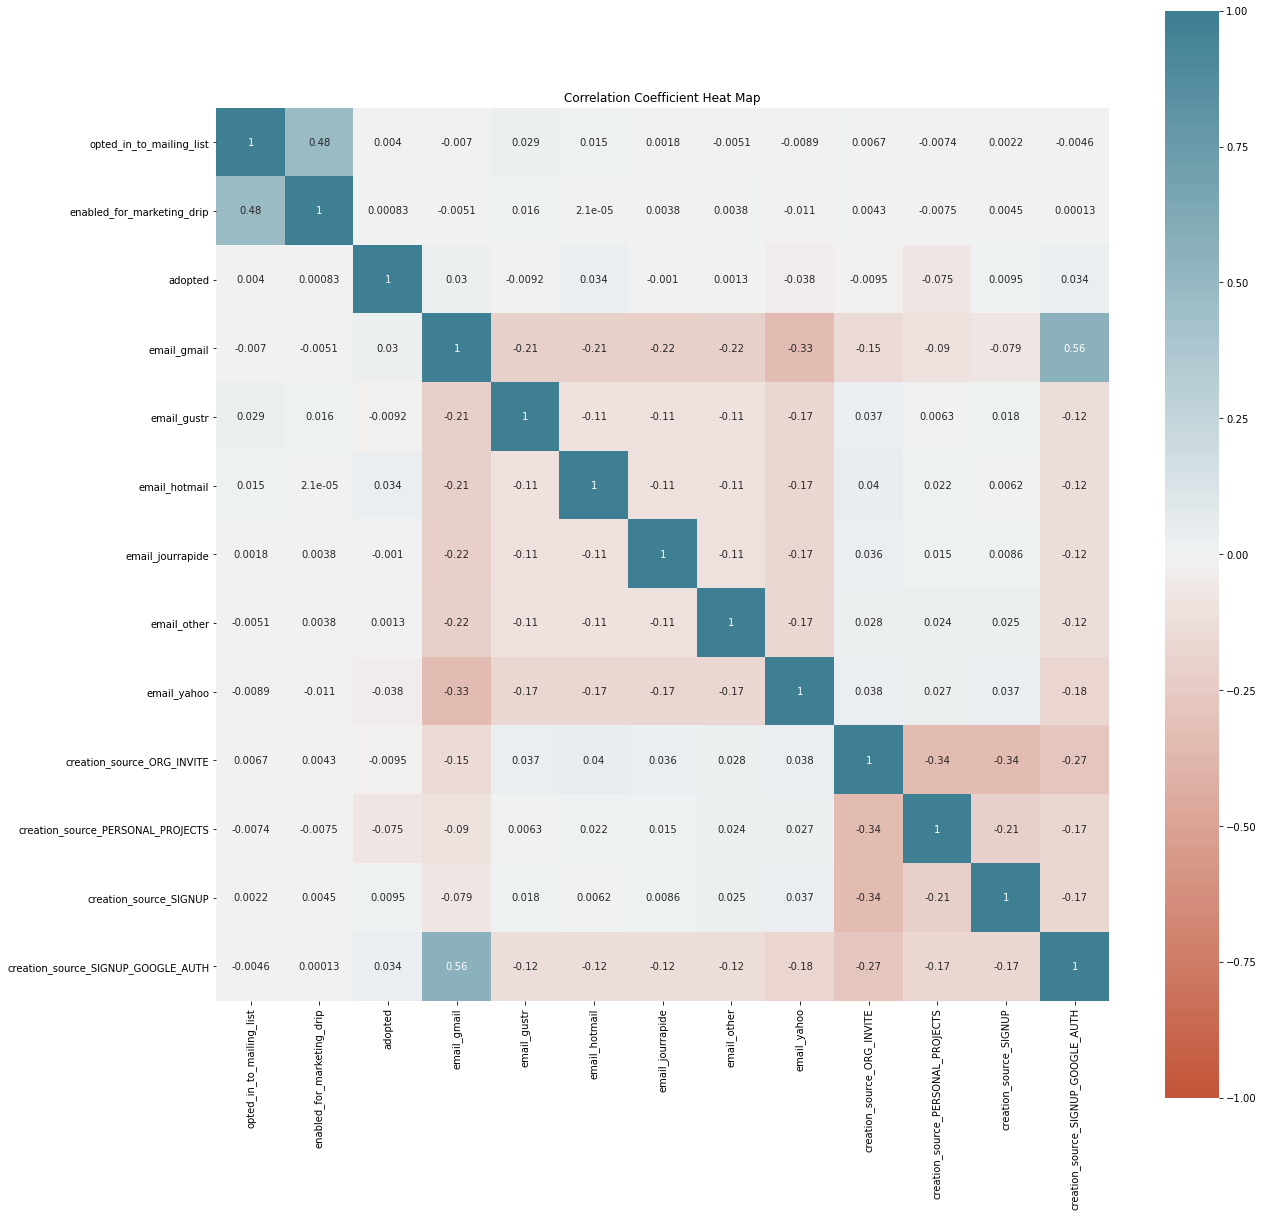

In [51]:
# heatmap of continous and boolean data, removing categorical data
corr = df.drop(columns=['logged_in_atleast_once', 'invited_by_user']).corr()

_ = plt.figure(figsize=(20,20))
_ = sns.heatmap(corr, vmin=-1, vmax=1, center=0, \
                cmap=sns.diverging_palette(20, 220, n=200), \
                square=True, annot=True)
_ = plt.title('Correlation Coefficient Heat Map')


plt.show()
plt.close()

In [52]:
df.adopted.value_counts()

False    10568
True      1432
Name: adopted, dtype: int64

Data are clearly imbalanced. We are most interested in True case, so let's resample with equal number of False and true values.

In [53]:
10568//1432

7

In [54]:
falsesubset = df.loc[df.loc[:, 'adopted'] == False].sample(1432*2, replace=False, random_state=42)
truesubset = df.loc[df.loc[:, 'adopted'] == True]

In [55]:
dfsubset = pd.concat([falsesubset, truesubset])

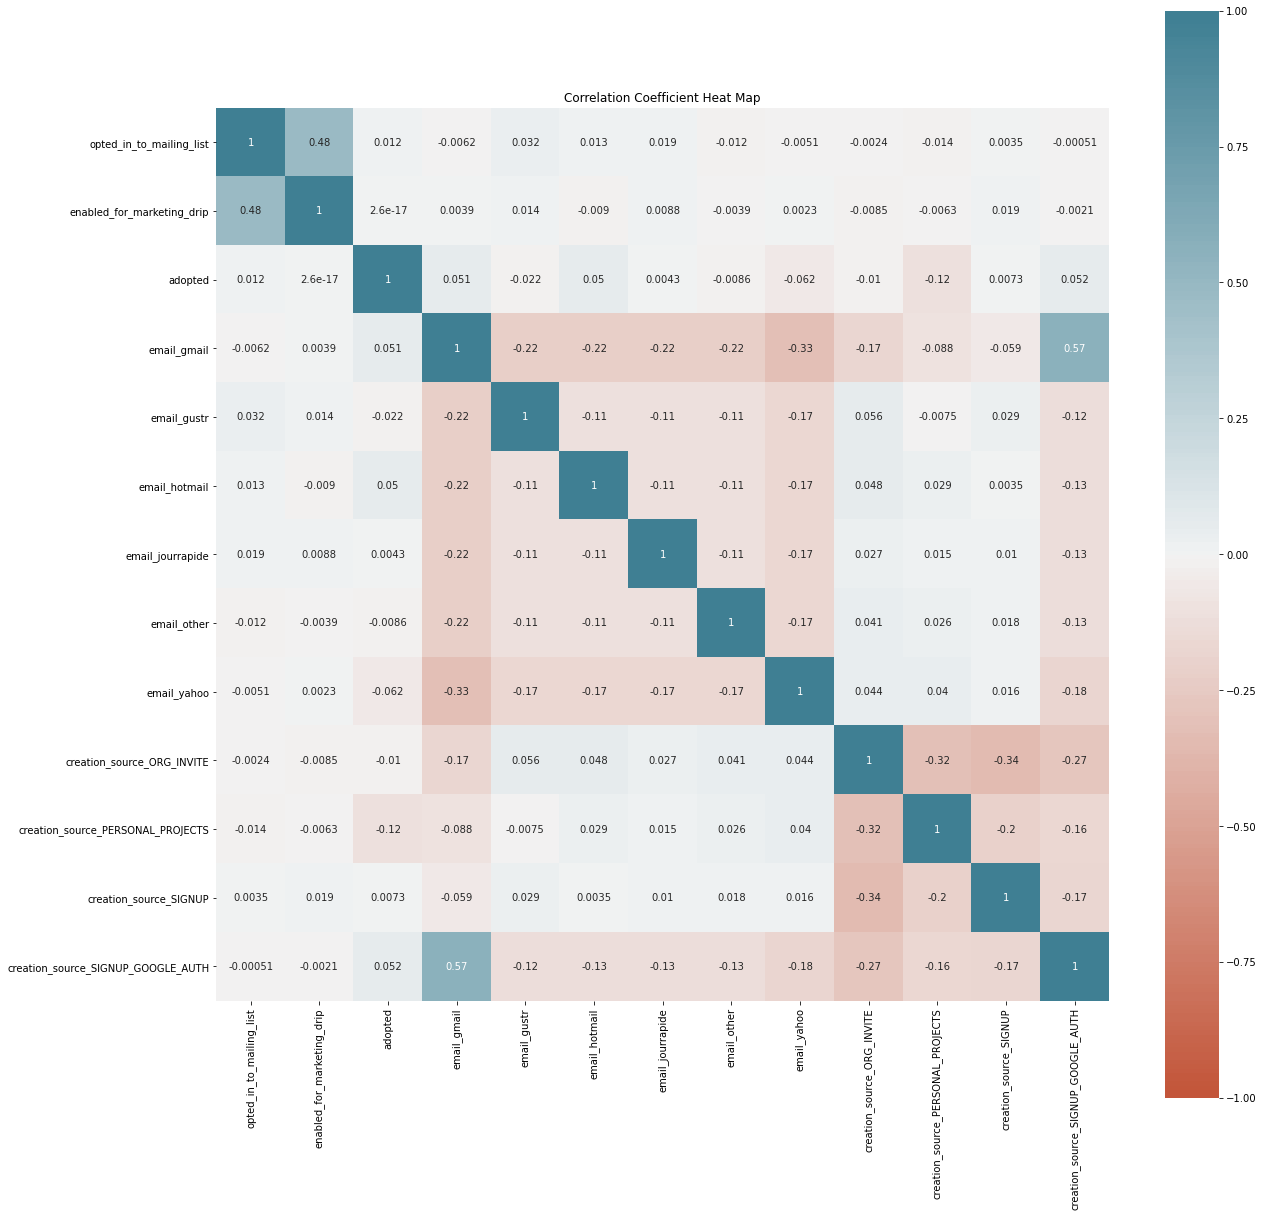

In [56]:
# heatmap of continous and boolean data, removing categorical data
corr = dfsubset.drop(columns=['logged_in_atleast_once', 'invited_by_user']).corr()

_ = plt.figure(figsize=(20,20))
_ = sns.heatmap(corr, vmin=-1, vmax=1, center=0, \
                cmap=sns.diverging_palette(20, 220, n=200), \
                square=True, annot=True)
_ = plt.title('Correlation Coefficient Heat Map')


plt.show()
plt.close()

In [282]:
df.loc[df.loc[:, 'creation_source_PERSONAL_PROJECTS'] == True].adopted.value_counts()

False    1970
True      141
Name: adopted, dtype: int64

In [285]:
df.loc[df.loc[:, 'creation_source_ORG_INVITE'] == True].adopted.value_counts()

False    3764
True      490
Name: adopted, dtype: int64

In [286]:
df.loc[df.loc[:, 'creation_source_SIGNUP_GOOGLE_AUTH'] == True].adopted.value_counts()

False    1177
True      208
Name: adopted, dtype: int64

In [278]:
df.loc[df.loc[:, 'enabled_for_marketing_drip'] == True].adopted.value_counts()

False    1577
True      215
Name: adopted, dtype: int64

In [279]:
df.loc[df.loc[:, 'opted_in_to_mailing_list'] == True].adopted.value_counts()

False    2630
True      364
Name: adopted, dtype: int64

In [280]:
df.loc[df.loc[:, 'invited_by_user'] == True].adopted.value_counts()

False    10568
True      1432
Name: adopted, dtype: int64

In [146]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [147]:
X = df.drop(columns='adopted')
y = df['adopted'] 

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

#### Decision Tree Classifier

In [149]:
from sklearn.tree import DecisionTreeClassifier

In [150]:
from sklearn.model_selection import RandomizedSearchCV

In [151]:
DecTree = DecisionTreeClassifier(class_weight={True:7, False:1})

In [152]:
scores = cross_validate(DecTree, X_train, y_train, scoring=scoring, cv=5)

In [153]:
print('mean precision score = ' + str(round(scores['test_precision'].mean(), 3)))
print('mean recall score = ' + str(round(scores['test_recall'].mean(), 3)))
print('mean f1 score = ' + str(round(scores['test_f1'].mean(), 3)))

mean precision score = 0.145
mean recall score = 0.543
mean f1 score = 0.229


In [154]:
params = {'criterion':['gini', 'entropy'], 
          'splitter':['best', 'random'], 
          'min_samples_split': np.arange(2, 10, 1), 
          'min_samples_leaf': np.arange(1, 10, 1)}

In [155]:
RS1 = RandomizedSearchCV(DecTree,
                         param_distributions=params,
                         scoring='recall',
                         n_iter=100,
                         cv=5)

In [156]:
RS1.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=DecisionTreeClassifier(class_weight={False: 1,
                                                                  True: 7}),
                   n_iter=100,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'splitter': ['best', 'random']},
                   scoring='recall')

In [157]:
print('best recall score = ' + str(round(RS1.best_score_, 3)))

best recall score = 0.545


In [158]:
RS1.best_params_

{'splitter': 'random',
 'min_samples_split': 3,
 'min_samples_leaf': 6,
 'criterion': 'gini'}

#### Random Forest Classifier

In [159]:
from sklearn.ensemble import RandomForestClassifier

In [160]:
RFC = RandomForestClassifier(class_weight={True: 7, False:1},
                             n_jobs=-2)

In [161]:
scores = cross_validate(RFC, X_train, y_train, scoring=scoring, cv=5)

In [162]:
print('mean precision score = ' + str(round(scores['test_precision'].mean(), 3)))
print('mean recall score = ' + str(round(scores['test_recall'].mean(), 3)))
print('mean f1 score = ' + str(round(scores['test_f1'].mean(), 3)))

mean precision score = 0.143
mean recall score = 0.494
mean f1 score = 0.222


In [163]:
params = {'criterion': ['gini', 'entropy'],
          'min_samples_split': np.arange(2, 30, 1),
          'min_samples_leaf': np.arange(1, 30, 1),
          'max_features': ['auto', 'sqrt', 'log2']}

In [164]:
RS2 = RandomizedSearchCV(RFC,
                           param_distributions=params,
                           scoring='recall',
                         n_iter=100,
                           cv=5)

In [165]:
RS2.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight={False: 1,
                                                                  True: 7},
                                                    n_jobs=-2),
                   n_iter=100,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
                   scoring='recall')

In [166]:
print('best recall score = ' + str(round(RS2.best_score_, 3)))

best recall score = 0.532


In [167]:
RS2.best_params_

{'min_samples_split': 17,
 'min_samples_leaf': 28,
 'max_features': 'sqrt',
 'criterion': 'gini'}

## Final Modeling

In [252]:
FinalModel = DecisionTreeClassifier(splitter='random',
                                    min_samples_split=3,
                                    min_samples_leaf=3,
                                    criterion='gini',
                                    class_weight={True:7,
                                                    False:1})

In [253]:
FinalModel.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={False: 1, True: 7}, min_samples_leaf=3,
                       min_samples_split=3, splitter='random')

In [254]:
y_pred = FinalModel.predict(X_test)

In [255]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.90      0.56      0.69      2634
        True       0.15      0.55      0.23       366

    accuracy                           0.56      3000
   macro avg       0.52      0.56      0.46      3000
weighted avg       0.81      0.56      0.64      3000



In [267]:
featureimportances = FinalModel.feature_importances_

In [268]:
cols = X.columns

In [269]:
featureimportances = pd.DataFrame({'Features':cols, 
                                  'Importance':featureimportances})

In [270]:
featureimportances = featureimportances.sort_values('Importance', ascending=False).reset_index(drop=True)

In [271]:
featureimportances

,Features,Importance
0,creation_source_PERSONAL_PROJECTS,0.299788
1,enabled_for_marketing_drip,0.174794
2,opted_in_to_mailing_list,0.134569
3,creation_source_ORG_INVITE,0.071800
4,email_jourrapide,0.064408
5,email_hotmail,0.061055
6,creation_source_SIGNUP,0.049676
7,email_other,0.049154
8,email_yahoo,0.040621
9,email_gustr,0.032604


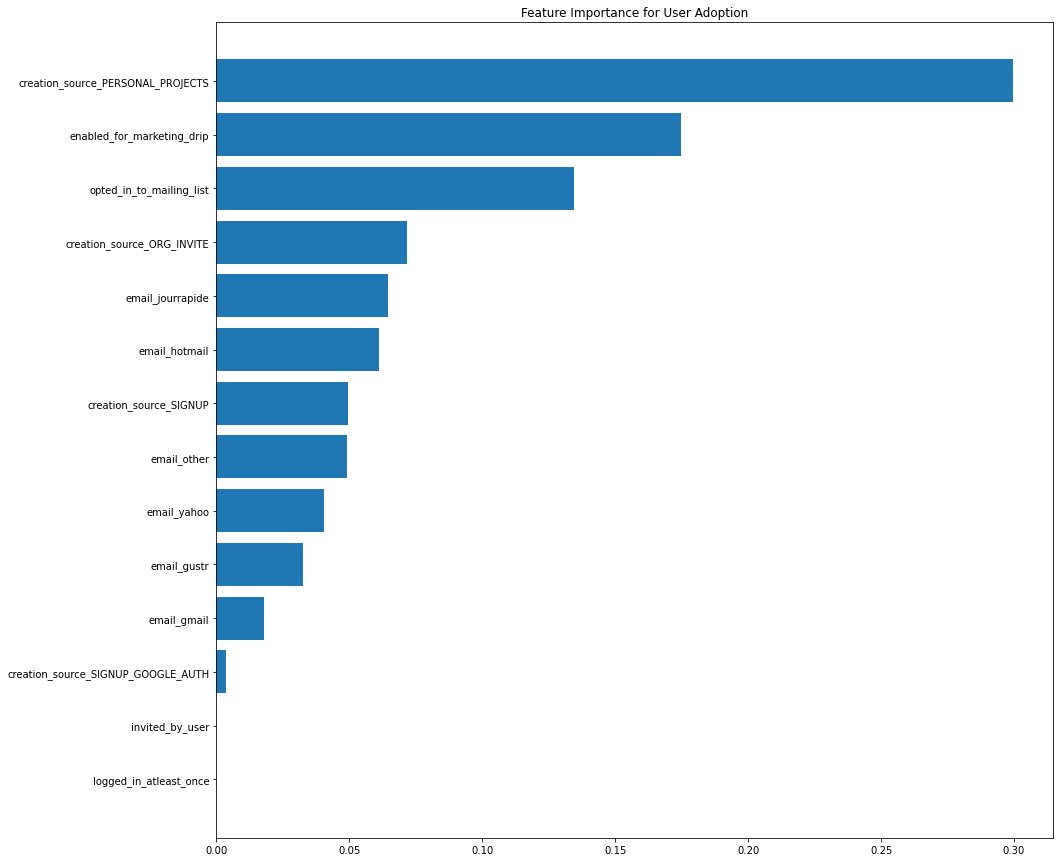

In [272]:
featureimportances = featureimportances.sort_values('Importance', ascending=True)
_ = plt.figure(figsize=(15,15))
_ = plt.barh(featureimportances.Features, featureimportances.Importance)
_ = plt.title('Feature Importance for User Adoption')
_ = plt.show()